In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv, find_dotenv
dotenv_path = find_dotenv()
print(load_dotenv(dotenv_path=dotenv_path))

True


In [3]:
import pandas as pd
import numpy as np
import mplfinance as mpf
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import scipy.stats as stats
from src.crypto.import_utils import (
    import_crypto_prices_cryptocompare, 
    import_crypto_prices_coingecko,
    import_crypto_prices_binance
)

import seaborn as sns
from src.crypto.utils import (compute_log_returns, 
                              compute_percentage_changes,
                              adf_test,
                              kpss_test
)

In [4]:
first_fetch = False

In [5]:
# Define numeric columns for consistent dtypes
numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'quote_volume', 
                'taker_base_volume', 'taker_quote_volume', 'trades']

if first_fetch:
    df = import_crypto_prices_binance(limit = 10, current = False)
    df['time_stamp'] = pd.to_datetime(df['time_stamp'])
    # Ensure numeric types
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.set_index('time_stamp').sort_index()
    df.to_csv("../data/binance/hbar.csv")
else:
    # Read with numeric dtypes specified
    dtype_dict = {col: 'float64' for col in numeric_cols}
    df_past = pd.read_csv("../data/binance/hbar.csv", 
                          parse_dates=['time_stamp'], 
                          index_col='time_stamp',
                          dtype=dtype_dict)
    last_timestamp = df_past.index[-1]
    current_time = pd.Timestamp.now()
    hours_diff = int((current_time - last_timestamp) // pd.Timedelta(hours=1))
    print(f"Hours difference: {hours_diff}")
    if hours_diff > 1:
        df_current = import_crypto_prices_binance(limit = hours_diff)
        df_current['time_stamp'] = pd.to_datetime(df_current['time_stamp'])
        # Ensure numeric types
        for col in numeric_cols:
            if col in df_current.columns:
                df_current[col] = pd.to_numeric(df_current[col], errors='coerce')
        df_current = df_current.set_index('time_stamp').sort_index()
        df = pd.concat([df_past, df_current], axis=0)
        df = df[~df.index.duplicated(keep='last')]  # Remove any duplicate timestamps
        df.to_csv("../data/binance/hbar.csv")
    else:
        df = df_past

Hours difference: 482


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44262 entries, 2020-12-20 15:00:00 to 2026-01-08 15:00:00
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open                44262 non-null  float64
 1   high                44262 non-null  float64
 2   low                 44262 non-null  float64
 3   close               44262 non-null  float64
 4   volume              44262 non-null  float64
 5   close_time          44262 non-null  int64  
 6   quote_volume        44262 non-null  float64
 7   trades              44262 non-null  float64
 8   taker_base_volume   44262 non-null  float64
 9   taker_quote_volume  44262 non-null  float64
 10  ignore              44262 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 4.1+ MB


### Hourly Prices

In [7]:
df_hourly = df.copy()

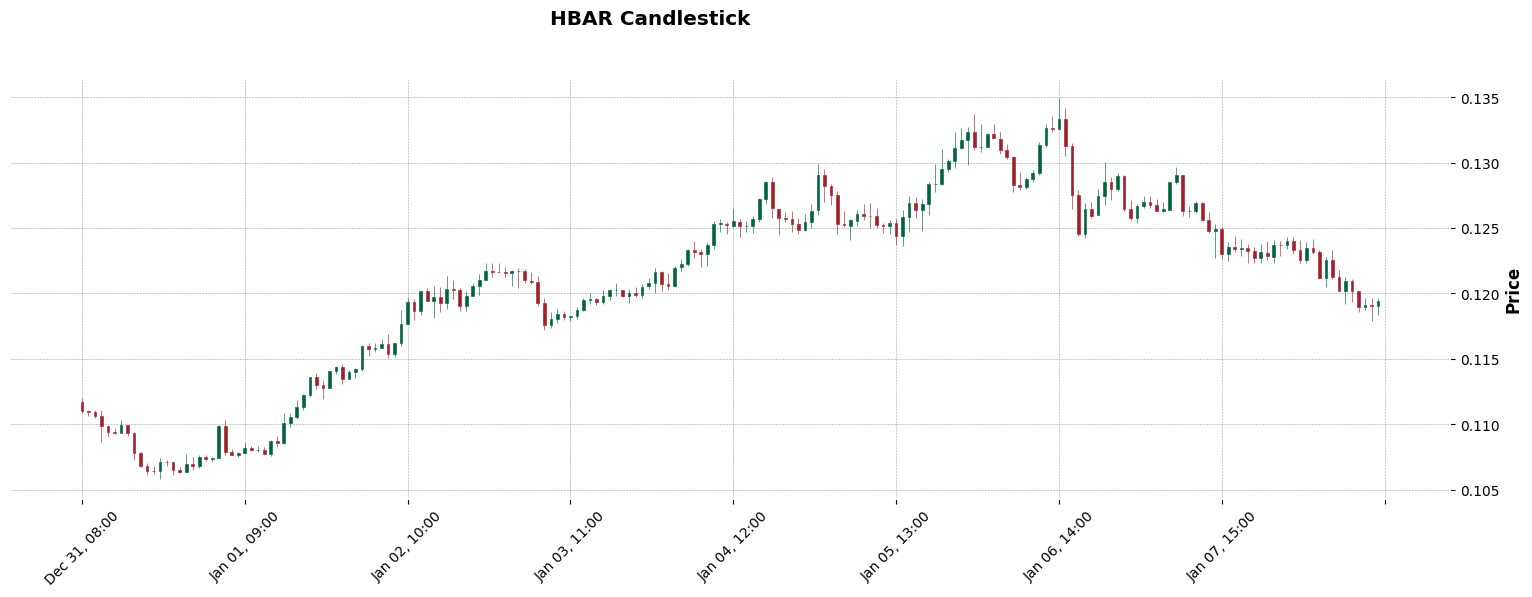

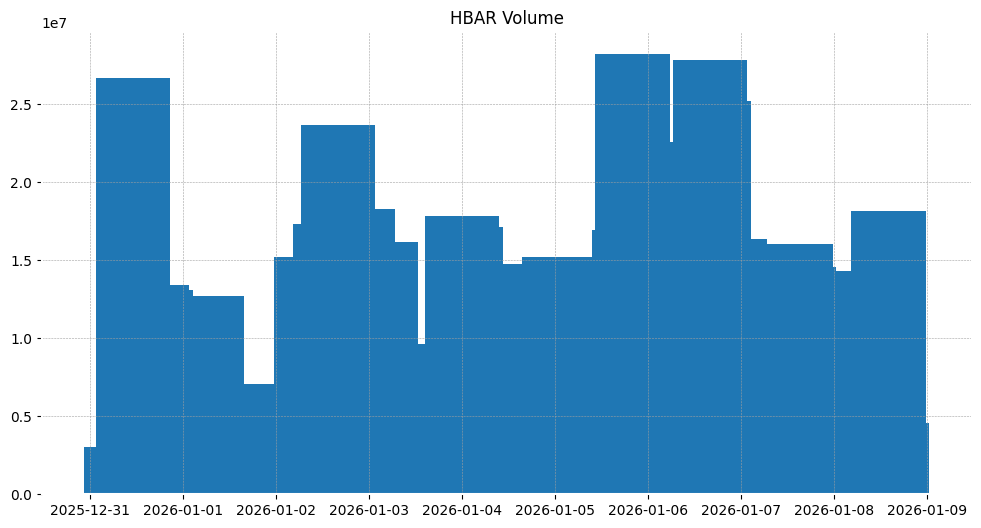

In [8]:
df_plot = df_hourly[-200:].copy()

# ---- Candlestick chart ----
mpf.plot(
    df_plot,
    type="candle",
    style="charles",
    volume=False,
    title="HBAR Candlestick",
    figsize = (20,6)
)

# ---- Volume chart (separate) ----
plt.figure(figsize=(12,6))
plt.bar(df_plot.index, df_plot["volume"], width=0.8)
plt.title("HBAR Volume")
plt.show()

In [9]:
df_hourly['pct_change']  = compute_percentage_changes(df_hourly['close'])
df_hourly['log_return']= compute_log_returns(df_hourly['close'])
df_hourly = df_hourly.dropna()

In [10]:
df_hourly['pct_change'].mul(100).describe()

count    44261.000000
mean         0.010948
std          1.293388
min        -17.354438
25%         -0.521739
50%          0.000000
75%          0.525394
max         37.390671
Name: pct_change, dtype: float64

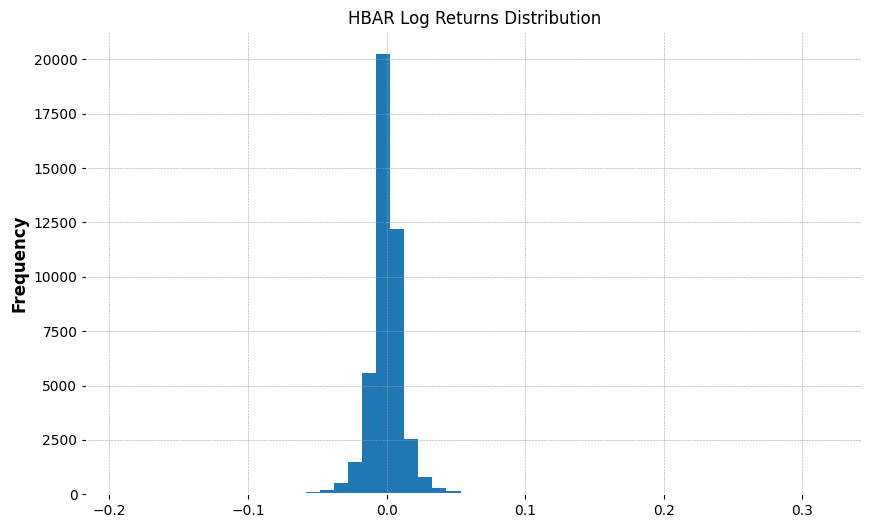

In [11]:
df_hourly.log_return.plot(kind='hist', bins=50, figsize=(10,6), title="HBAR Log Returns Distribution")
plt.show()

In [12]:
# Find all candles where the open price is greater than the previous close price
df_hourly[(df_hourly.open - df_hourly.close.shift()) > 0.001]

,open,high,low,close,volume,close_time,quote_volume,trades,taker_base_volume,taker_quote_volume,ignore,pct_change,log_return
time_stamp,,,,,,,,,,,,,
2021-03-11 00:00:00,0.22100,0.22151,0.21182,0.21338,9465187.6,1615424399999,2.045967e+06,6292.0,4100817.2,8.874812e+05,0,-0.030091,-0.030553
2021-05-19 13:00:00,0.21921,0.26271,0.16000,0.23124,64328587.0,1621432799999,1.382147e+07,36287.0,29970852.0,6.532377e+06,0,0.070556,0.068178


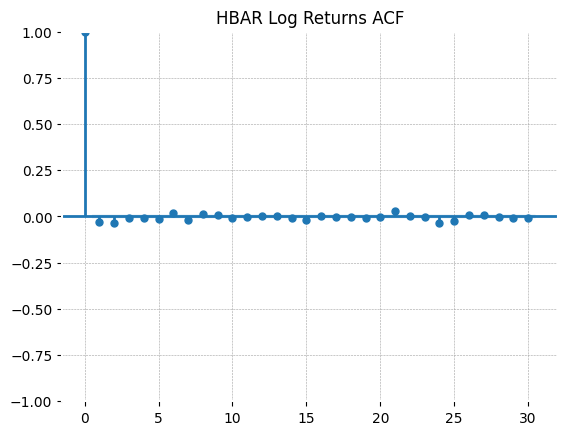

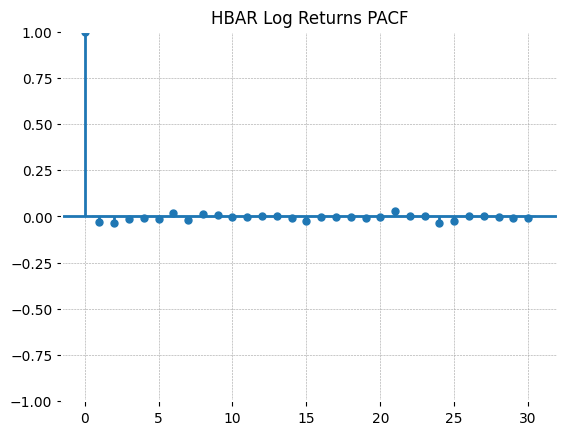

In [14]:
plot_acf(df_hourly['log_return'], lags=30, title="HBAR Log Returns ACF");
plot_pacf(df_hourly['log_return'], lags=30, title="HBAR Log Returns PACF");

In [15]:
# Perform ADF test: time series stationarity test
adf_test(df_hourly['log_return'])
print("\n")
# Perform KPSS test: time series stationarity test
kpss_test(df_hourly['log_return'])

Results of Dickey-Fuller Test:
Test Statistic                   -39.532995
p-value                            0.000000
#Lags Used                        31.000000
Number of Observations Used    44229.000000
Critical Value (1%)               -3.430498
Critical Value (5%)               -2.861605
Critical Value (10%)              -2.566805
dtype: float64


Results of KPSS Test:
Test Statistic            0.151653
p-value                   0.100000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


D:\My Files\Projects\Python\trade-tools\src\crypto\utils.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


### Daily Prices

In [16]:
df_daily = df_hourly.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).reset_index()

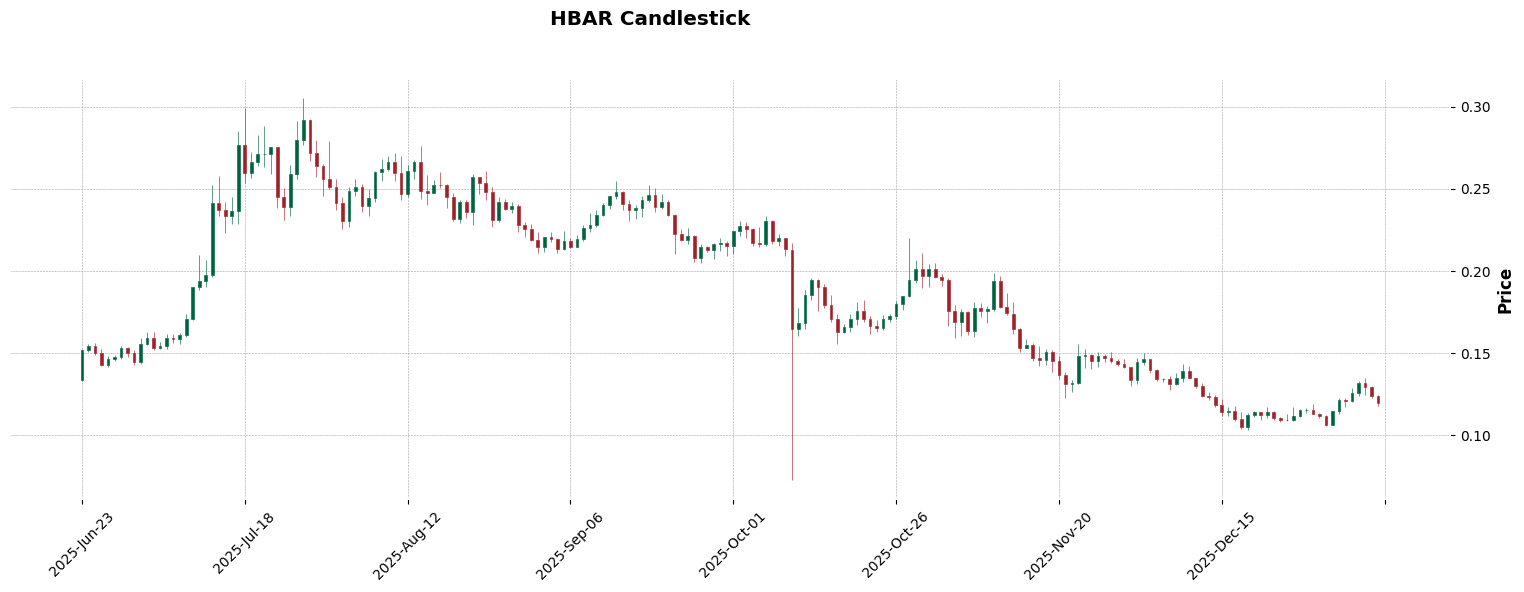

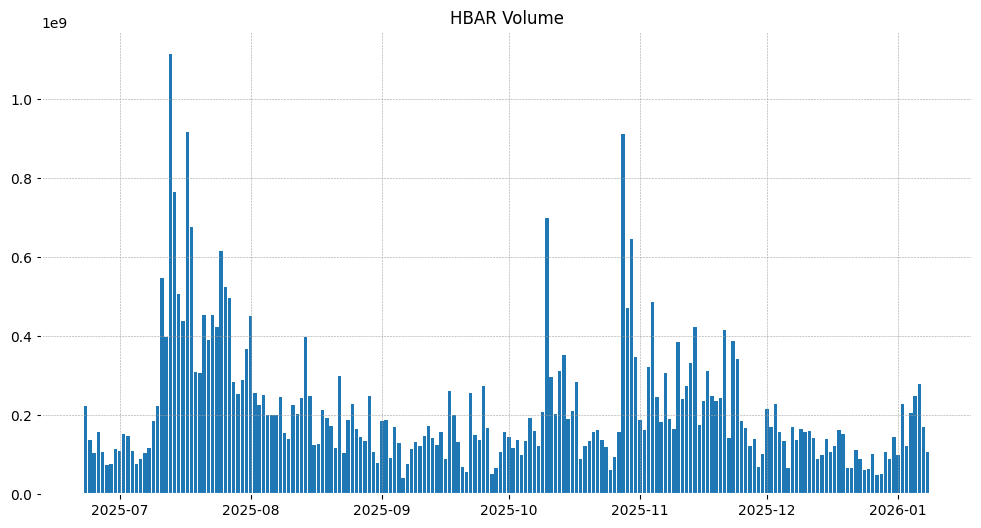

In [17]:
df_plot = df_daily[-200:].copy()
df_plot = df_plot.set_index("time_stamp")

# ---- Candlestick chart ----
mpf.plot(
    df_plot,
    type="candle",
    style="charles",
    volume=False,
    title="HBAR Candlestick",
    figsize = (20,6)
)

# ---- Volume chart (separate) ----
plt.figure(figsize=(12,6))
plt.bar(df_plot.index, df_plot["volume"], width=0.8)
plt.title("HBAR Volume")
plt.show()

In [18]:
df_daily['pct_change']  = compute_percentage_changes(df_daily['close'])
# derive correlation features
df_daily['log_return'] = np.log(df_daily['close'].shift(-1) / df_daily['close'])
threshold = 0.0 # 5% threshold
df_daily['target'] = np.where(df_daily['log_return'] - threshold >= 0, 1, 0)
df_daily = df_daily.dropna()

In [19]:
df_daily['log_return'].mul(100).describe()

count    1844.000000
mean        0.064027
std         5.932313
min       -44.897004
25%        -2.913499
50%         0.000000
75%         2.442727
max        54.753297
Name: log_return, dtype: float64

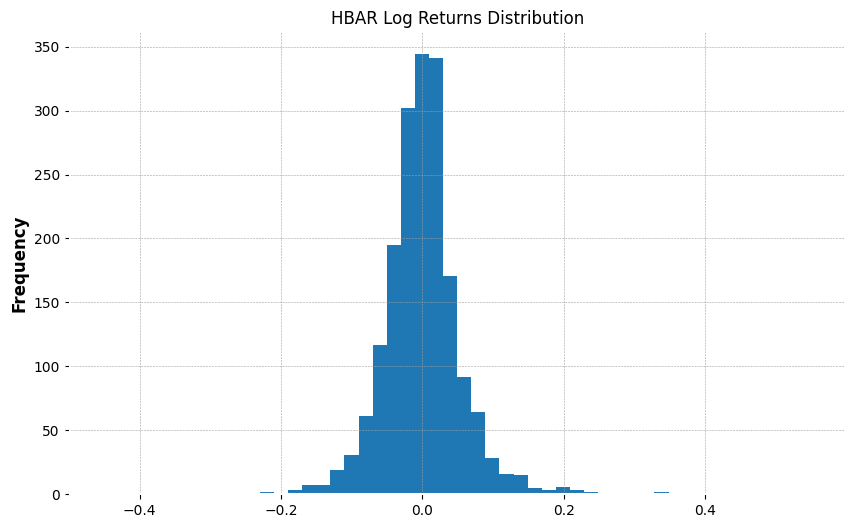

In [20]:
df_daily.log_return.plot(kind='hist', bins=50, figsize=(10,6), title="HBAR Log Returns Distribution")
plt.show()

In [21]:
# Find all candles where the open price is greater than the previous close price
df_daily[(df_daily.open - df_daily.close.shift()) > 0.001]

,time_stamp,open,high,low,close,volume,pct_change,log_return,target
81,2021-03-11,0.221,0.27888,0.20851,0.26945,527482887.3,0.224773,0.008021,1


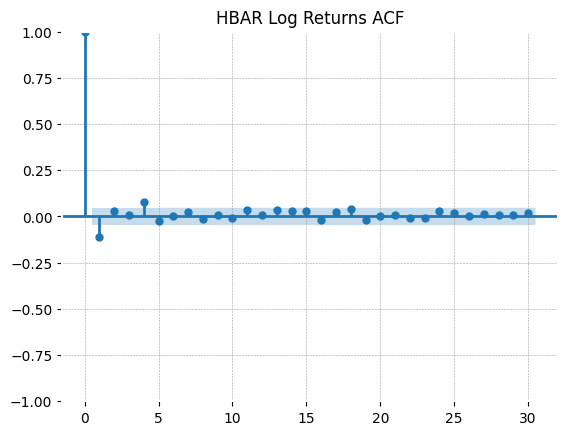

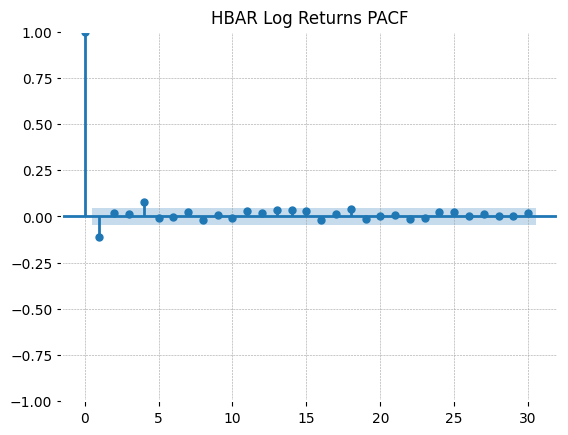

In [22]:
plot_acf(df_daily['log_return'], lags=30, title="HBAR Log Returns ACF");
plot_pacf(df_daily['log_return'], lags=30, title="HBAR Log Returns PACF");

In [23]:
# Perform ADF test: time series stationarity test
adf_test(df_daily['log_return'])
print("\n")
# Perform KPSS test: time series stationarity test
kpss_test(df_daily['log_return'])

Results of Dickey-Fuller Test:
Test Statistic                  -19.856826
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1840.000000
Critical Value (1%)              -3.433909
Critical Value (5%)              -2.863112
Critical Value (10%)             -2.567607
dtype: float64


Results of KPSS Test:
Test Statistic           0.159625
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


D:\My Files\Projects\Python\trade-tools\src\crypto\utils.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


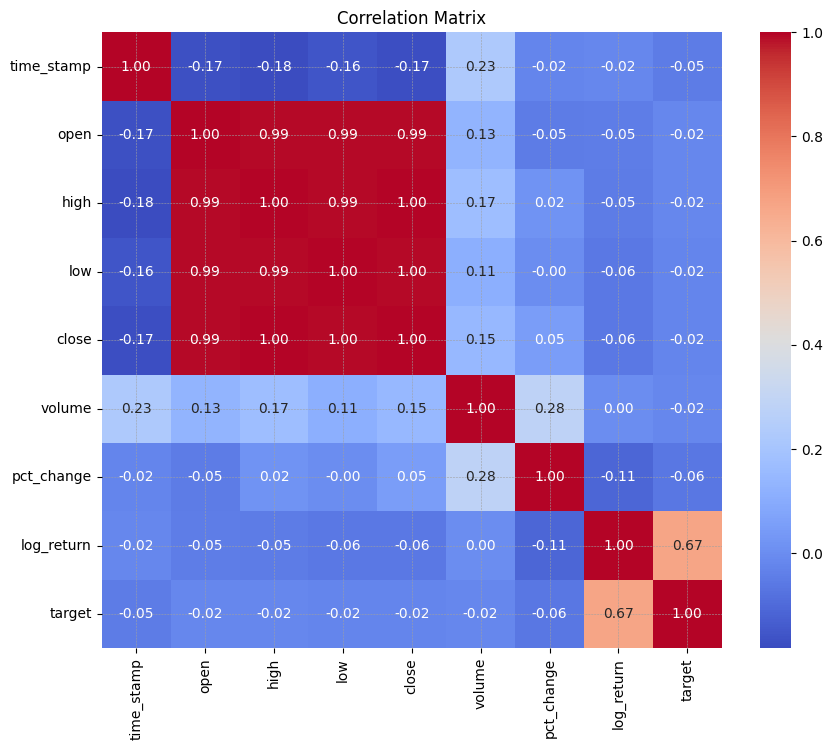

In [24]:
# correlation matrix
corr = df_daily.corr()
plt.figure(figsize=(10, 8))
plt.title("Correlation Matrix")
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()